# Assignment 1-1: K-Nearest Neighbors (k-NN)

In this notebook you will implement a K-Nearest Neighbors classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Recall that the K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.

After implementing the K-Nearest Neighbor classifier, you will use *cross-validation* to find the best value of K.

The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

## Downloading the CIFAR-10 dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
import download

In [2]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
download.maybe_download_and_extract(url,download_dir)

- Download progress: 100.0%
Download finished. Extracting files.
Done.


## Loading raw files and reading them as training and testing datasets

In [3]:
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Visualizing dataset samples
To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

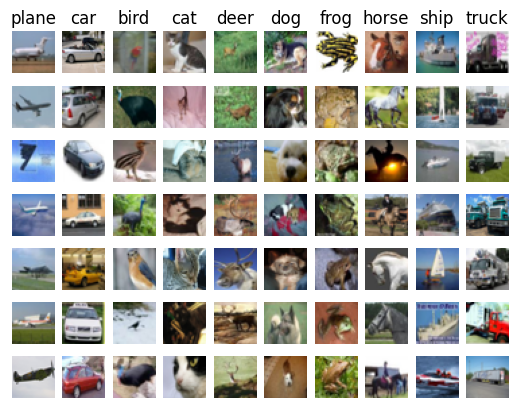

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

We will subsample the data to use only 500 training examples and 250 test examples:

In [5]:
# Memory error prevention by subsampling data

num_training = 500
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 250
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(500, 3072) (250, 3072)


# K-Nearest Neighbors (k-NN)

Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. Perform k-Nearest neighbours algorithm on the CiFAR-10 dataset to classify test images.
2. Perform k-fold cross validation and plot the trend line with error bars that correspond to standard deviation to find the best value of the 'k' hyper parameter and best accuracy on the dataset.
3. Select the best value for k, and rerun the classifier on our full 5000 set of training examples.
4. Discussion: Discuss your understanding.

In [7]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Flatten the images: convert each 32x32x3 image to a 1D vector of length 3072 (32*32*3)
X_train_flatten = X_train.reshape(X_train.shape[0], -1)  # Shape (50000, 3072)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)      # Shape (10000, 3072)

# Normalize the pixel values (scale between 0 and 1)
X_train_flatten = X_train_flatten / 255.0
X_test_flatten = X_test_flatten / 255.0

# Reshape y_train and y_test from (n, 1) to (n,)
y_train = y_train.flatten()
y_test = y_test.flatten()

# Define the k-NN classifier with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
knn.fit(X_train_flatten, y_train)

# Predict on the test data
y_pred = knn.predict(X_test_flatten)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of k-NN on CIFAR-10: {accuracy:.2f}')


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Accuracy of k-NN on CIFAR-10: 0.34


In [8]:
# Memory error prevention by subsampling data

num_training = 1000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 300
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [9]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(1000, 3072) (300, 3072)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Flatten the images: convert each 32x32x3 image to a 1D vector of length 3072 (32*32*3)
X_train_flatten = X_train.reshape(X_train.shape[0], -1)  # Shape (50000, 3072)

# Normalize the pixel values (scale between 0 and 1)
X_train_flatten = X_train_flatten / 255.0

# Reshape y_train from (n, 1) to (n,)
y_train = y_train.flatten()

# Hyperparameter k values to try
k_values = list(range(1, 21))

# Store mean accuracy and standard deviation for each k
mean_accuracy = []
std_accuracy = []

# Perform 5-fold cross-validation for each value of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)

    # Perform cross-validation (5-fold) and capture accuracy scores
    cv_scores = cross_val_score(knn, X_train_flatten, y_train, cv=5, scoring='accuracy')

    # Record the mean and standard deviation of the cross-validation results
    mean_accuracy.append(np.mean(cv_scores))
    std_accuracy.append(np.std(cv_scores))

# Plot the accuracy trend with error bars representing standard deviation
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, mean_accuracy, yerr=std_accuracy, fmt='-o', capsize=5, capthick=2)
plt.title('k-NN Accuracy with Varying k (CIFAR-10)')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-validated Accuracy')
plt.grid(True)
plt.show()

# Find the best value of k (max accuracy)
best_k = k_values[np.argmax(mean_accuracy)]
best_accuracy = max(mean_accuracy)

print(f'The best value of k is: {best_k}')
print(f'The best cross-validated accuracy is: {best_accuracy:.2f}')


KeyboardInterrupt: 

In [15]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Flatten the images: convert each 32x32x3 image to a 1D vector of length 3072 (32*32*3)
X_train_flatten = X_train.reshape(X_train.shape[0], -1)  # Shape (50000, 3072)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)      # Shape (10000, 3072)

# Normalize the pixel values (scale between 0 and 1)
X_train_flatten = X_train_flatten / 255.0
X_test_flatten = X_test_flatten / 255.0

# Reshape y_train and y_test from (n, 1) to (n,)
y_train = y_train.flatten()
y_test = y_test.flatten()

# Best k value obtained from previous cross-validation (example: k=5)
best_k = 5  # Replace with the actual best k value

# Define the k-NN classifier with the best k
knn = KNeighborsClassifier(n_neighbors=best_k)

# Fit the model on the full training data
knn.fit(X_train_flatten[:5000], y_train[:5000])  # Using 5000 samples for training

# Predict on the test data
y_pred = knn.predict(X_test_flatten)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of k-NN with k={best_k} on CIFAR-10 test set: {accuracy:.2f}')


Accuracy of k-NN with k=5 on CIFAR-10 test set: 0.27


In [22]:
from collections import Counter
import numpy as np

# KNN Classifier function
def knn_predict(X_train, y_train, X_test, k=3):
    predictions = []
    for test_point in X_test:
        # Compute L2 (Euclidean) distance from test_point to all training points
        distances = np.linalg.norm(X_train - test_point, axis=1)

        # Find the k-nearest neighbors
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = [y_train[i] for i in k_indices]

        # Majority vote
        # Convert NumPy arrays to hashable types (e.g., tuples or scalars)
        # before using them in Counter
        k_nearest_labels = [label.item() if isinstance(label, np.ndarray) and label.size == 1 else tuple(label)
                            for label in k_nearest_labels]

        # Convert NumPy arrays to hashable types (e.g., tuples or scalars)
        # before using them in Counter
        k_nearest_labels = [label.item() if isinstance(label, np.ndarray) else label for label in k_nearest_labels]

        most_common = Counter(k_nearest_labels).most_common(1)[0][0]
        predictions.append(most_common)

    return predictions # Add this line to return predictions


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

# Function to perform K-Fold Cross Validation
def k_fold_cross_validation(X, y, k=5, neighbors=3):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Create KFold object
    fold_accuracies = []

    # Loop over each fold
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # Train KNN on the current fold
        y_pred_fold = knn_predict(X_train_fold, y_train_fold, X_test_fold, k=neighbors)

        # Evaluate the fold's accuracy
        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
        fold_accuracies.append(fold_accuracy)

    # Calculate mean accuracy across all folds
    mean_accuracy = np.mean(fold_accuracies)
    print(f'Mean accuracy across {k} folds: {mean_accuracy:.2f}')
    return mean_accuracy

# Example usage to perform K-Fold Cross Validation with KNN
k = 5  # Number of folds
neighbors = 3  # Number of neighbors for KNN
k_fold_cross_validation(X_train, y_train, k=k, neighbors=neighbors)
